In [7]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from droneWatchML.preprocessing import *
# from droneWatchML.process import *
# from droneWatchML.viz import *
# import json
import os
import numpy as np
# import imageio
# from unittest import TestCase

from torch.autograd import Variable
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time
from shapeSorter import SimpleSegmentationDataset

In [2]:
!gpustat

tethys  Sat Apr 14 08:51:47 2018
[0] GeForce GTX 1080 Ti | 35'C,   2 % |     0 / 11170 MB |
[1] GeForce GTX 1080 Ti | 28'C,  23 % |  2489 / 11172 MB | jjalma(2479M)


x: (256, 256, 3) y: (256, 256, 3)


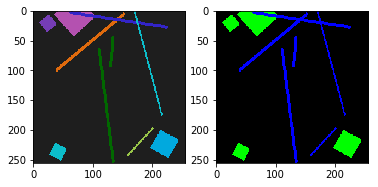

In [3]:
patch_size = 256
n_max = 12
dataset = SimpleSegmentationDataset( patch_size, n_max, alpha =1.0,virtual_size=1000)
sample=dataset.__getitem__(3)

x=sample["input"]
y=sample["groundtruth"]
print("x:", x.shape, "y:", y.shape)
plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)
plt.show()

## Model

In [16]:
class gated_resnet(nn.Module):
    """
    Gated Residual Block
    """
    def __init__(self, num_filters, kernel_size, padding, nonlinearity=nn.ReLU, dropout=0.2,gated=True):
        super(gated_resnet, self).__init__()
        self.gated = gated
        num_hidden_filters =2 * num_filters if gated else num_filters
        self.conv_input = nn.Conv2d(num_filters, num_hidden_filters, kernel_size=kernel_size,stride=1,padding=padding )
        self.dropout = nn.Dropout2d(dropout)
        self.nonlinearity = nonlinearity()
        self.batch_norm1 = nn.BatchNorm2d(num_hidden_filters)
        self.conv_out = nn.Conv2d(num_hidden_filters, num_hidden_filters, kernel_size=kernel_size,stride=1,padding=padding )
        self.batch_norm2 = nn.BatchNorm2d(num_filters)

    def forward(self, og_x):
        x = self.conv_input(og_x)
        x = self.batch_norm1(x)
        x = self.nonlinearity(x)
        x = self.dropout(x)
        x = self.conv_out(x)
        if self.gated:
            a, b = torch.chunk(x, 2, dim=1)
            c3 = a * F.sigmoid(b)
        else:
            c3 = x
        out = og_x + c3
        out = self.batch_norm2(out)
        return out
    
class ConvolutionalEncoder(nn.Module):
    """
    Convolutional Encoder providing skip connections
    """
    def __init__(self,n_features_input,num_hidden_features,kernel_size,padding,n_resblocks,gated=True,dropout=0.2):
        """
        n_features_input (int): number of input features
        num_hidden_features (list(int)): number of features for each stage
        kernel_size (int): convolution kernel size
        padding (int): convolution padding
        n_resblocks (int): number of residual blocks at each stage
        gated (bool): use gated convolutions
        dropout (float): dropout probability
        """
        super(ConvolutionalEncoder,self).__init__()
        self.n_features_input = n_features_input
        self.num_hidden_features = num_hidden_features
        self.stages = nn.ModuleList()
        # input convolution block
        block = [nn.Conv2d(n_features_input, num_hidden_features[0], kernel_size=kernel_size,stride=1, padding=padding)]
        for _ in range(n_resblocks):
            block += [gated_resnet(num_hidden_features[0], kernel_size, padding,gated=gated, dropout=dropout)]
        self.stages.append(nn.Sequential(*block))
        # layers
        for features_in,features_out in [num_hidden_features[i:i+2] for i in range(0,len(num_hidden_features), 1)][:-1]:
            # downsampling
            block = [nn.Conv2d(features_in, features_out, kernel_size=kernel_size,stride=2,padding=padding )]#,nn.ReLU(),nn.BatchNorm1d(2*features_out)]
            # residual blocks
            for _ in range(n_resblocks):
                block += [gated_resnet(features_out, kernel_size, padding,gated=gated, dropout=dropout)]
            self.stages.append(nn.Sequential(*block)) 
            
    def forward(self,x):
        skips = []
        for stage in self.stages:
            x = stage(x)
            skips.append(x)
        return x,skips
    def getInputShape(self):
        return (-1,self.n_features_input,-1,-1)
    def getOutputShape(self):
        return (-1,self.num_hidden_features[-1], -1,-1)
    
            
class ConvolutionalDecoder(nn.Module):
    """
    Convolutional Decoder taking skip connections
    """
    def __init__(self,n_features_output,num_hidden_features,kernel_size,padding,n_resblocks,gated=True,dropout=0.2):
        """
        n_features_output (int): number of output features
        num_hidden_features (list(int)): number of features for each stage
        kernel_size (int): convolution kernel size
        padding (int): convolution padding
        n_resblocks (int): number of residual blocks at each stage
        gated (bool): use gated convolutions
        dropout (float): dropout probability
        """
        super(ConvolutionalDecoder,self).__init__()
        self.n_features_output = n_features_output
        self.num_hidden_features = num_hidden_features
        self.upConvolutions = nn.ModuleList()
        self.skipMergers = nn.ModuleList()
        self.residualBlocks = nn.ModuleList()
        # input convolution block
        # layers
        for features_in,features_out in [num_hidden_features[i:i+2] for i in range(0,len(num_hidden_features), 1)][:-1]:
            # downsampling
            self.upConvolutions.append(nn.ConvTranspose2d(features_in, features_out, kernel_size=2, stride=2,padding=0 ))#,nn.ReLU(),nn.BatchNorm1d(2*features_out)]
            self.skipMergers.append(nn.Conv2d(2*features_out, features_out, kernel_size=kernel_size,stride=1, padding=padding))
            # residual blocks
            block = []
            for _ in range(n_resblocks):
                block += [gated_resnet(features_out, kernel_size, padding,gated=gated, dropout=dropout)]
            self.residualBlocks.append(nn.Sequential(*block))   
        # output convolution block
        block = [nn.Conv2d(num_hidden_features[-1],n_features_output, kernel_size=kernel_size,stride=1, padding=padding)]
        self.output_convolution = nn.Sequential(*block)

    def forward(self,x, skips):
        for up,merge,conv,skip in zip(self.upConvolutions,self.skipMergers, self.residualBlocks,skips):
            x = up(x)
            cat = torch.cat([x,skip],1)
            x = merge(cat)
            x = conv(x)
        return self.output_convolution(x)
    def getInputShape(self):
        return (-1,self.num_hidden_features[0],-1,-1)
    def getOutputShape(self):
        return (-1,self.n_features_output, -1,-1)
    
class UNet(nn.Module):
    """
    U-Net model with dynamic number of layers, dropout and batch normalization
    """
    def __init__(self, in_channels, out_channels, num_hidden_features,n_resblocks, dropout=0, batch_norm=True, gated=False, padding=1, kernel_size=3):
        """
        initialize the model
        Args:
            in_channels (int): number of input channels (image=3)
            out_channels (int): number of output channels (n_classes)
            depth (int): number of down/up layers
            n_features (int): number of initial features
            dropout (float): float in [0,1]: dropout probability
            batch_norm (bool): use batch normalization or not
        """
        super(UNet, self).__init__()
        self.encoder = ConvolutionalEncoder(in_channels,num_hidden_features,kernel_size,padding,n_resblocks,gated=gated,dropout=dropout)
        self.decoder = ConvolutionalDecoder(out_channels,num_hidden_features[::-1],kernel_size,padding,n_resblocks,gated=gated,dropout=dropout)
        
    def forward(self, x):
        x,skips = self.encoder(x)
        x = self.decoder(x,skips[:-1][::-1])
        return x

NameError: name 'nn' is not defined

## MODEL VAL

In [35]:
# from droneWatchML.modules import UNet
# from unet_val import UNet
from unet_meli import UNet, weights_init
cuda = True
in_channels = 3
out_channels = 3#4
depth = 3#4
# num_hidden_features = [32,64,128]
n_features_zero = 32#64
dropout = 0.1
batch_size = 8
# n_resblocks = 2
# gated = True
try:
    del model
except:
    0
#model = UNet(in_channels, out_channels, depth = depth, n_features_zero = n_features_zero, dropout=dropout, batch_norm=True)
# model = UNet2(in_channels, out_channels, num_hidden_features = num_hidden_features,n_resblocks=n_resblocks, dropout=dropout, batch_norm=True, gated=gated)
model=UNet(in_channels,out_channels,depth,n_features_zero,dropout)
model.apply(weights_init)
print('### Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

if cuda:
    model.cuda()
    
loss_fn = nn.CrossEntropyLoss()
def criterion(y_,y): 
    y = y.permute(0,2,3,1).contiguous()
    y = y.view(-1,y.size()[-1])
    y_ = y_.permute(0,2,3,1).contiguous()
    y_ = y_.view(-1,y.size()[-1])
    y = y.max(-1)[1]
    return loss_fn(y_, y)#.mean()

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0,drop_last=True)
global_step = 0
epoch = 0
prev_valid = 9999
num_epochs = 2
learning_rate = 1e-2
reduce_lr_steps = [1,5, 10, 100,200]
# dis = updatable_display2(['train'], ["epoch", "loss" , "lr" ] )
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Total params: 1.93M


In [36]:
def draw_update(global_step,loss,lr,axs):
    ite=np.arange(global_step)
    axs[0].clear()
    axs[1].clear()
    line1, = axs[0].plot(ite, loss, 'r-') 
    line2, = axs[1].plot(ite, lr, 'b-') 
    fig.canvas.draw()
    

## Training

<IPython.core.display.Javascript object>


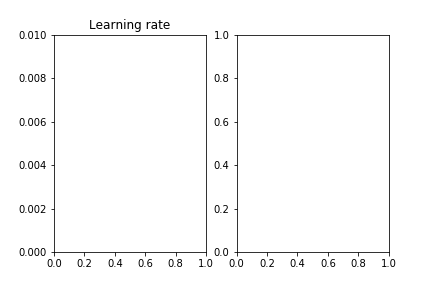

interrupted


In [37]:
%matplotlib notebook
loss_train=[]
lr_train=[]

plt.ion()


fig,axs =plt.subplots(1, 2)

axs[0].set_ylim(0,0.01)
axs[0].set_title('Loss train')
axs[1].set_ylim(0,1)
axs[0].set_title('Learning rate')
# fig.show()
# fig.canvas.draw()

try:
    while epoch < num_epochs:
        if epoch in reduce_lr_steps:
            learning_rate = learning_rate * 0.3
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # TRAIN
        model.train()
        for i, sample in enumerate(dataloader):
            x=sample["input"]
            y=sample["groundtruth"]
            x = Variable(x.float())
            x=x.permute(0,3,1,2)
            y = Variable(y.float())
            y=y.permute(0,3,1,2)
            if cuda:
                x = x.cuda()
                y = y.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            y_ = model.forward(x)
            loss = criterion(y_, y)
            loss.backward()
            optimizer.step()
            
            loss_train.append(loss.data[0])
            lr_train.append(learning_rate)
#             dis.update( global_step, 'train', {"epoch" : epoch, "loss": loss.data[0], "lr":learning_rate} )
            global_step += 1
            if global_step % 10 == 0:
#                 dis.display()
                print('Training Epoch %d global step %d loss %f lr %f'%(epoch,global_step,loss.data[0],learning_rate))
                draw_update(len(loss_train),loss_train,lr_train,axs)
                time.sleep(1)


        #print ('Epoch [%d/%d], Iter [%d/%d] Loss: (train) %.4f / (test) %.4f ' 
        #       %(config.epoch+1, config.num_epochs, i+1, len(dataset)//batch_size, loss.data[0], np.mean(ls)))
        epoch += 1
except KeyboardInterrupt:
    print("interrupted")

## reconstruction

ref: (8, 256, 256, 3) | pred: (8, 256, 256)


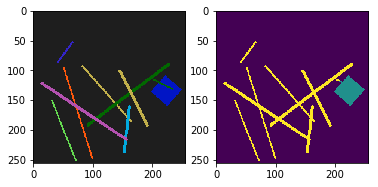

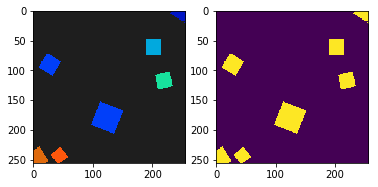

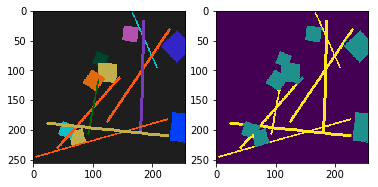

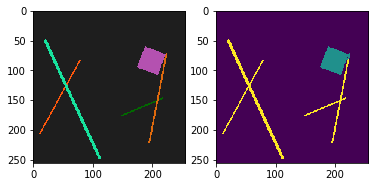

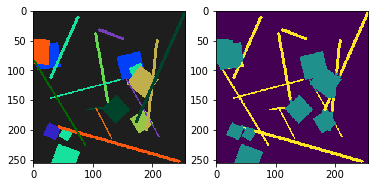

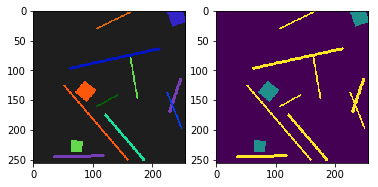

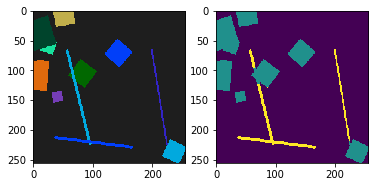

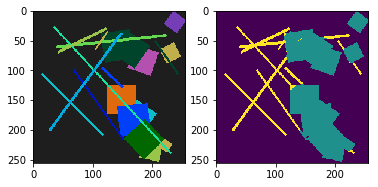

In [15]:
# def unstackSegmentation(seg):
#     canvas = np.zeros((*seg.shape,3))
#     canvas[:,:,0] = (seg == 1)
#     canvas[:,:,1] = (seg == 2)
#     canvas[:,:,2] = (seg == 3)
#     return canvas
sample = next(iter(dataloader))
x=sample["input"]
x=x.permute(0,3,1,2)
y=sample["groundtruth"]
y=y.permute(0,3,1,2)
x = Variable(x.float())
y = Variable(y.float())
if cuda:
    x = x.cuda()
    y = y.cuda()
# Forward + Backward + Optimize
optimizer.zero_grad()
y_ = model.forward(x)
ref = x.cpu().data.numpy().transpose([0,2,3,1])
target = y.cpu().data.numpy().transpose([0,2,3,1])
pred = np.argmax(y_.cpu().data.numpy().transpose([0,2,3,1]),-1)
print("ref:", ref.shape, "| pred:", pred.shape)
for k in range(min(batch_size,10)):
    plt.subplot(1,2,1)
    plt.imshow(ref[k])
    plt.subplot(1,2,2)
    plt.imshow(pred[k])
    plt.show()
    
del x,y

In [21]:
pred[k].shape

(256, 4)

In [21]:
y_.cpu().data.numpy().transpose([0,2,3,1])

array([[[[  9.5207405,  -8.996064 ,  -8.954443 ],
         [ 11.301346 , -10.69848  , -10.484265 ],
         [ 11.34561  , -10.714323 , -10.561078 ],
         ...,
         [ 11.097832 , -10.51308  , -10.288073 ],
         [ 11.020935 , -10.446529 , -10.19529  ],
         [  9.342781 ,  -8.842331 ,  -8.750384 ]],

        [[ 11.11554  , -10.538288 , -10.326224 ],
         [ 13.742735 , -13.042121 , -12.5985985],
         [ 13.821842 , -13.070538 , -12.73202  ],
         ...,
         [ 13.409247 , -12.735575 , -12.275366 ],
         [ 13.263104 , -12.609222 , -12.104634 ],
         [ 10.785775 , -10.247314 ,  -9.959425 ]],

        [[ 11.144186 , -10.548731 , -10.38553  ],
         [ 13.791197 , -13.059521 , -12.697603 ],
         [ 13.895938 , -13.102805 , -12.862839 ],
         ...,
         [ 13.403909 , -12.701093 , -12.317574 ],
         [ 13.19248  , -12.51675  , -12.08317  ],
         [ 10.6880245, -10.143839 ,  -9.8963995]],

        ...,

        [[ 11.063881 , -10.482016 , -1

In [28]:
target.shape

(8, 256, 256, 3)